In [33]:
# Import all Math tools:
#-----------------------
import numpy as np
from scipy import integrate
from scipy.spatial.distance import directed_hausdorff
# Plotting tools
from matplotlib import pyplot as plt
# we use the following for plotting figures in jupyter
%matplotlib inline
plt.style.use('default')

import warnings
warnings.filterwarnings('ignore')

# GPy: Gaussian processes library
import GPy
# Figure dpi
dpi = 72

import timeit

import sys
from IPython.display import clear_output

def update_progress(progress):
    bar_length = 20
    if isinstance(progress, int):
        progress = float(progress)
    if not isinstance(progress, float):
        progress = 0
    if progress < 0:
        progress = 0
    if progress >= 1:
        progress = 1

    block = int(round(bar_length * progress))

    clear_output(wait = True)
    text = "Progress: [{0}] {1:.1f}%".format( "#" * block + "-" * (bar_length - block), progress * 100)
    print(text)

## 2) Experiment I: Cobweb of GP Posterior Fit of a 1D Map

### Function Defintions

In [8]:
def GP_Predict_Point(x0):
    Xstar = np.linspace(x0,x0, 1).reshape(-1, 1)
    Ystar, Vstar = m.predict(Xstar)
    Ystar = Ystar[0][0]
    return Ystar

def GP_Predict_Array(X):
    Xstar = np.linspace(X,X, 1).reshape(-1, 1)
    Ystar, Vstar = m.predict(Xstar)
    return Ystar

def plot_cobweb_GP(r0,x0,fig,ax,bx):
    x = Xnew
    # Plot y = f(x) and y = x
    ax.plot(x,mean[:,0],c='#444444',lw=1)
    ax.plot(x, x, c='#444444', lw=1)
    # Iterate x = f(x) for nmax steps, starting at (x0, 0).
    px, py = np.empty((2,2*nmax+1,2))
    px[0], py[0] = x0, 0
    for n in range(1, 2*nmax, 2):
        px[n] = px[n-1]
        Xstar = np.linspace(px[n-1][0],px[n-1][0], 1).reshape(-1, 1)
        Ystar, Vstar = m.predict(Xstar)
        Ystar = np.append(Ystar[0],Ystar[0])
        py[n] = Ystar #f(px[n-1])
        px[n+1] = py[n]
        py[n+1] = py[n]
    # Plot the path traced out by the iteration.
    ax.plot(px, py, c='b', alpha=0.7, lw=1)
    # Annotate and tidy the plot.
    ax.minorticks_on()
    ax.grid(which='minor', alpha=0.5, ls='--')
    ax.grid(which='major', alpha=0.5, ls='--')
    ax.set_aspect('equal')
    ax.set_xlabel(r'$x$')
    ax.set_ylabel(r'${one}x(1-x)$'.format(one = r0))
    ax.set_title(r'$x_0 = {one}, r = {two}$'.format(one = x0, two = r0))#ax.set_title(r'$x_0 = {:.1}$'.format(x0))
    ax.set_ylim(bottom=0,top=1.05)
    ax.set_xlim(left=0,right=1.05)
    # ->
    n = range(0,nmax+1)
    xn = []
    for i in n:
        xn.append(x0)
        Xstar = np.linspace(x0,x0, 1).reshape(-1, 1)
        Ystar, Vstar = m.predict(Xstar)
        x0 = Ystar[0][0] #f(x0)
    bx.plot(n, xn, c='b', alpha=0.7, lw=1, ls='-', marker='o')
    bx.minorticks_on()
    bx.grid(which='minor', alpha=0.5, ls='--')
    bx.grid(which='major', alpha=0.5, ls='--')
    bx.set_xlabel(r'$n$')
    bx.set_ylabel(r'$x_n$')
    #bx.set_ylim(bottom=-0.1, top=1.1)
    bx.set_xlim(left=0)
    
def plot_cobweb_f(r0,x0,fig,ax,bx):
    x = np.linspace(0,1,500)
    # Plot y = f(x) and y = x
    ax.plot(x,f(x),"k:",lw=2)
#     ax.plot(x, x, c='#444444', lw=1)
    # Iterate x = f(x) for nmax steps, starting at (x0, 0).
    px, py = np.empty((2,2*nmax+1,2))
    px[0], py[0] = x0, 0
    for n in range(1, 2*nmax, 2):
        px[n] = px[n-1]
        py[n] = f(px[n-1])
        px[n+1] = py[n]
        py[n+1] = py[n]
    # Plot the path traced out by the iteration.
    ax.plot(px, py, c='tab:orange', alpha=0.7, lw=1)
    # Annotate and tidy the plot.
#     ax.minorticks_on()
#     ax.grid(which='minor', alpha=0.5, ls='--')
#     ax.grid(which='major', alpha=0.5, ls='--')
#     ax.set_aspect('equal')
#     ax.set_xlabel(r'$x$')
#     ax.set_ylabel(r'${one}x(1-x)$'.format(one = r0))
#     ax.set_title(r'$x_0 = {one}, r = {two}$'.format(one = x0, two = r0))#ax.set_title(r'$x_0 = {:.1}$'.format(x0))
#     ax.set_ylim(bottom=0)
#     ax.set_xlim(left=0)
    n = range(0,nmax+1)
    xn = []
    for i in n:
        xn.append(x0)
        x0 = f(x0)
    bx.plot(n, xn, c='tab:orange', alpha=0.7, lw=1, ls='-', marker='o')
#     bx.minorticks_on()
#     bx.grid(which='minor', alpha=0.5, ls='--')
#     bx.grid(which='major', alpha=0.5, ls='--')
#     bx.set_xlabel(r'$n$')
#     bx.set_ylabel(r'$x_n$')
#     #bx.set_ylim(bottom=-0.1, top=1.1)
#     bx.set_xlim(left=0)

def f_bif(x,r0):
    return r0*x*(1-x)

def plot_bifurcation(r1,r2,fig,ax1):
    n = 10000
    r0 = np.linspace(r1, r2, n)
    iterations = 1000
    last = 100
    x = 1e-5 * np.ones(n)
    for i in range(iterations):
        x = f_bif(x,r0)
        # We display the bifurcation diagram.
        if i >= (iterations - last):
            ax1.plot(r0, x, ',k', alpha=.25, lw=1)
    ax1.set_xlim(r1, r2)
    ax1.set_xlabel("r"), ax1.set_ylabel("x")
    ax1.set_title("Bifurcation diagram of f")
    ax1.minorticks_on()
    plt.tight_layout()
    
def time_series_dist(x0,N):
    n = range(0,N)
    xn = []
    for i in n:
        xn.append(x0)
        x0 = f(x0)
    return np.array(xn)

Declump: Works well for 1D. For higher dimensions (in future experiments), consider this: https://en.wikipedia.org/wiki/Closest_pair_of_points_problem

In [9]:
def declump(X,N,iterations):
    X = np.sort(X.transpose()[0])
    dst_btwn_cnsc_pnts = [np.abs(X[i]-X[i-1]) for i in range(1,len(X))]
    smllst_dst_index = np.argmin(dst_btwn_cnsc_pnts)
    X = np.delete(X,smllst_dst_index) # delete the left sample point
    
    for i in range(0,iterations-1):
        if smllst_dst_index > 1:
            dst_btwn_cnsc_pnts =  dst_btwn_cnsc_pnts[0:smllst_dst_index-1] + [np.abs(X[smllst_dst_index]-X[smllst_dst_index-1])] + dst_btwn_cnsc_pnts[smllst_dst_index+1 : len(X)]
        elif smllst_dst_index == 1:
            dst_btwn_cnsc_pnts = [np.abs(X[smllst_dst_index]-X[smllst_dst_index-1])] + dst_btwn_cnsc_pnts[smllst_dst_index+1 : len(X)]
        else:
            dst_btwn_cnsc_pnts = dst_btwn_cnsc_pnts[smllst_dst_index+1 : len(X)]

        smllst_dst_index = np.argmin(dst_btwn_cnsc_pnts)
        X = np.delete(X,smllst_dst_index) # delete the left sample point
        
    X = X[:,None]
    N = N - iterations
    return X, N;

In [10]:
import timeit

N = 2000
X = np.linspace(0, 1, N)[:,None]
start_time = timeit.default_timer()
X,N = declump(X,N,1500)
elapsed = timeit.default_timer() - start_time
print(elapsed)

0.244675799999996


In [11]:
def Get_GP_Orbit_Points(x0,nmax,m):
    # Iterate x = f(x) for nmax steps, starting at (x0, 0).
    px, py = np.empty((2,2*nmax+1,2))
    px[0], py[0] = x0, 0
    for n in range(1, 2*nmax, 2):
        px[n] = px[n-1]
        Xstar = np.linspace(px[n-1][0],px[n-1][0], 1).reshape(-1, 1)
        Ystar, Vstar = m.predict(Xstar)
        Ystar = np.append(Ystar[0],Ystar[0])
        py[n] = Ystar #f(px[n-1])
        px[n+1] = py[n]
        py[n+1] = py[n]
    return px, py;

def Get_f_Orbit_Points(x0,nmax,f):
    # Iterate x = f(x) for nmax steps, starting at (x0, 0).
    px, py = np.empty((2,2*nmax+1,2))
    px[0], py[0] = x0, 0
    for n in range(1, 2*nmax, 2):
        px[n] = px[n-1]
        py[n] = f(px[n-1])
        px[n+1] = py[n]
        py[n+1] = py[n]
    return px, py;

def Hausdorff(x0,nmax,m,f,transience_thresh):
    GP_X = Get_GP_Orbit_Points(x0,nmax+transience_thresh,m)[0].transpose()[0]
    f_X = Get_f_Orbit_Points(x0,nmax+transience_thresh,f)[0].transpose()[0]
    GP_Y = Get_GP_Orbit_Points(x0,nmax+transience_thresh,m)[1].transpose()[0]
    f_Y = Get_f_Orbit_Points(x0,nmax+transience_thresh,f)[1].transpose()[0]
    u = np.empty(2*(nmax)+1, dtype=object)
    v = np.empty(2*(nmax)+1, dtype=object)
    for i in range(transience_thresh,2*(nmax)+1+transience_thresh):
        u[i-transience_thresh] = (GP_X[i],GP_Y[i])
        v[i-transience_thresh] = (f_X[i],f_Y[i])
    u = u.tolist()
    v = v.tolist()
    return max(directed_hausdorff(u, v)[0], directed_hausdorff(v, u)[0])

### Experiment Tools

### Setup

#### Background on Time Series
A dynamical system in which time is discrete is called a difference equation, recursion relation, or iterated map. A time series is a series of data points indexed in time. <br>

#### Background on the Logistic Map
(1)<br>
The logistic map is
$$x_{n+1} = rx_n(1-x_n)$$
where $r$ is the bifurcation parameter, which corresponds to the growth rate of the population, and $x_0$ is a dimensionless initial population value. Based on certain values of $r$, the logisitc map behaves differently:
<ul>
    <li>For $r<1$, $x_n\rightarrow 0$ as $n\rightarrow \infty$.</li>
    <li>For $1<r<3$, the population approaches a nonzero steady state.</li>
    <li>For $r=3.3$, the map becomes a period-2 cycle, undergoing its first period doubling.</li>
    <li>For $r>r_\infty$, $x_n$ never stabilizes to a fixed point or cycle and the map is chaotic.</li>
</ul>
(/1)
<br>
(1) Steven Strogatz; Nonlinear Dynamics and Chaos with Applications to Physics, Biology, Chemistry, and Engineering

In [1]:
# 1) Choose the kernel. Construct the 1D RBF kernel:
k = GPy.kern.RBF(1,variance=1.,lengthscale=0.1,name="rbf")

# 2) Choose function and r-value. lambda function, call f(x) to generate data
r = 2
f = lambda x: r*x*(1-x)  #-np.cos(2*np.pi*x) + 0.5*np.sin(6*np.pi*x)

# 3) Choose number of sample locations
N = 10

# 4) Choose domain of sample points.
#X = np.linspace(0, 1, N)[:,None] #[:,None] turns data into column matrix
#X = np.random.uniform(0,1, N)[:,None]
X = time_series_dist(0.4,N)[:,None] #time_series_dist(x0,N)

NameError: name 'GPy' is not defined

In [54]:
# 5) Choose whether to de-clump the sample points:
#X,N = declump(X,N,2)

# 6) Choose how the observed data behave y = f(X) + epsilon
sd = 0
ep = np.random.normal(0., sd, (N,1)) #np.random.normal takes mean and s.d. (not variance), NOTE: 0.1^2 = 0.01; (N,1) => N-by-1 Matrix
Y = f(X) + ep


# ---------------
m = GPy.models.GPRegression(X, Y, k) 

# Constrain the regression parameters to be positive only
m.constrain_positive()

# Fix the Gaussian noise variance at sd**2 if ep != 0 
m.Gaussian_noise.variance = sd**2 # (Reset the parameter first)
m.Gaussian_noise.variance.fix()

# Reoptimise
m.optimize()
display(m)

# New test points to sample function from
Xnew = np.linspace(-0.05, 1.05, 100)[:, None]

# Get mean and covariance of optimised GP
mean, Cov = m.predict_noiseless(Xnew, full_cov=True)

reconstraining parameters GP_regression


GP_regression.,value,constraints,priors
rbf.variance,0.1628610460899256,+ve,
rbf.lengthscale,1.2451476302008935,+ve,
Gaussian_noise.variance,0.0,fixed +ve,


### Results

1) Figure: This figure shows the plot of the GP regression approximation of $f$ as determined from the sample points in comparison to the plot of $f$.

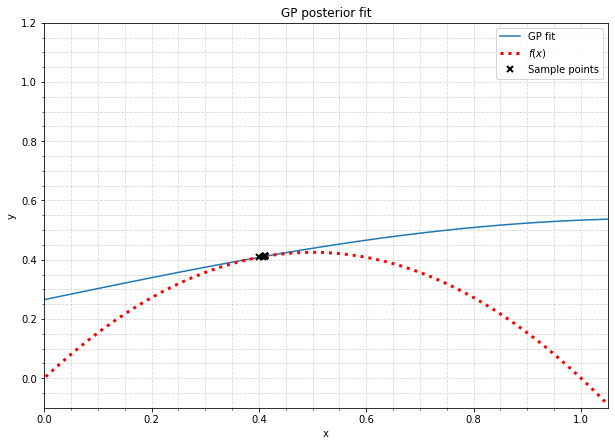

In [55]:
#First plot
fig = plt.figure(figsize=(1600/dpi,500/dpi),dpi=dpi)
ax = fig.add_subplot(121)
ax.plot(Xnew, mean[:,0], "-")
ax.set_xlabel("x"), ax.set_ylabel("y")
ax.set_title("GP posterior fit")

#Second plot
ax.plot(Xnew, f(Xnew),"r:", lw=3);
ax.legend(labels=["GP fit","$f(x)$"]);

#Third plot
training_points = (X,Y)
if training_points is not None:
    X_, Y_ = training_points
    ax.plot(X_, Y_, "kx", mew=2)
    ax.legend(labels=["GP fit","$f(x)$", "Sample points"])

# Organize plot
ax.minorticks_on()
ax.grid(which='minor', alpha=0.5, ls='--')
ax.grid(which='major', alpha=0.5, ls='--')
ax.set_xlim(left=0,right=1.05);
ax.set_ylim(bottom=-0.1, top=1.2);

#### Background on Functional Analysis: Function, Metric, and Lp Spaces
A function space is a vector space whose vectors are functions. (more info: http://www.math.usm.edu/lambers/mat415/lecture1.pdf)

2) Let $f$ be the 1D logisitc map and $g$ be the corresponding GP fit regression model which approximates $f$ using a set of sample points. We compute the $L_2[0,1]$ norm of the difference between $f$ and $g$:
$$\left\| f-g \right\|_2 = \sqrt{\int_0^1(f(x)-g(x))^2 dx}$$


In [56]:
#L2Norm = np.sqrt()
integrand = lambda x: (f(x) - GP_Predict_Point(x))**2
L2Norm = np.sqrt(integrate.quad(integrand, 0, 1))
print(L2Norm)

[1.99454861e-01 2.10159846e-08]


3) Figure: The plot on the left shows the cobweb of the GP regression fit (solid line) in comparison to the cobweb of $f$ (dotted line) with borth orbits starting at $x_0$. The plot on the right shows the time series of $x_n$ versus $n$, where $n$ is the $n$-th iteration of the one-dimensional map $f$.

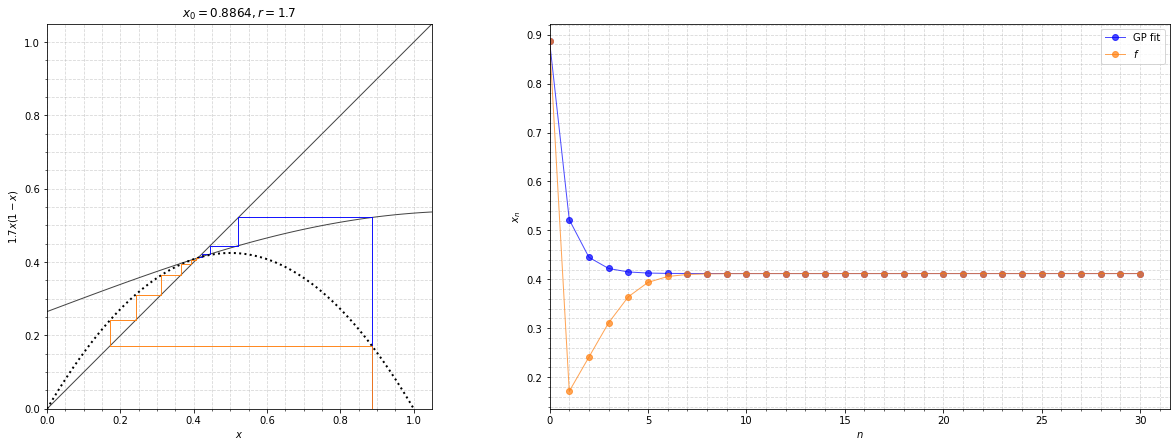

In [57]:
fig = plt.figure(figsize=(1600/dpi,500/dpi),dpi=dpi)
ax = fig.add_subplot(121)
bx = fig.add_subplot(122)

# First Plot
nmax = 30
r0 = r
x0 = 0.8864
plot_cobweb_GP(r0,x0,fig,ax,bx)

# Second Plot on top
plot_cobweb_f(r0,x0,fig,ax,bx)

bx.legend(labels=["GP fit", "$f$"]);
plt.subplots_adjust(wspace=0)
plt.show()

4) To measure the dissimilarity between the two orbits, we compute the Hausdorff distance.

In [58]:
Hausdorff(x0,nmax,m,f,1000)

1.2628945262600163e-05

### Experiment 1 a) Time series distribution with starting value 0.4
Relationship between $r$ and $H$ with varying $N$ and $x_0$. 

Setup Parameters

In [32]:
Nmax = 10 # max number of sample points
Nmin = 3
#--------------------
r1 = np.linspace(0.01, 3, 50)
r2 = np.linspace(3.01, 3.43, 50)
r3 = np.linspace(3.431, 3.45, 200)
r4 = np.linspace(3.451, 3.54, 50)
r5 = np.linspace(3.541, 3.56, 50)
r6 = np.linspace(3.561, 3.565, 50)
r7 = np.linspace(3.5651,3.5699, 200)
r8 = np.linspace(3.56991,3.5699461, 200)
r9 = np.linspace(3.569947,4,250)
r_range = np.concatenate((r1,r2,r3,r4,r5,r6,r7,r8,r9)) # range of r values
#r_range = np.linspace(0.01,4,3)
#-------------------
# choose one: 
x0_range = np.linspace(0.01,0.99,20)
#x0_range = np.linspace(0.01,0.99,3)
#x0_i = 0.2 # initial orbit position for cobweb
#------------------
# for time series dist only -> choose one:
#x0_time_dist_range = np.linspace(0.01,0.99,20)
x0_time_dist_i = 0.4 # time series dist x0 starting value
#------------------
nmax = 30 # max iterations of orbit for Hausdorff dist. calculation

Experiment: DO NOT RUN AGAIN!

In [33]:
Xnew = np.linspace(-0.05, 1.05, 100)[:, None]
result = []
N_Array = []
R = []
H = []

# -- Approximate Calculation Time: --
start_time = timeit.default_timer()

k = GPy.kern.RBF(1,variance=1.,lengthscale=0.1,name="rbf")
f = lambda x: 4*x*(1-x)
X = time_series_dist(0.4,Nmax)[:,None]
#X,N = declump(X,Nmax,2);
sd = 0
ep = np.random.normal(0., sd, (Nmax,1))
Y = f(X) + ep
m = GPy.models.GPRegression(X, Y, k)
m.constrain_positive(warning=False)
m.Gaussian_noise.variance = sd**2
m.Gaussian_noise.variance.fix()
m.optimize()
mean, Cov = m.predict_noiseless(Xnew, full_cov=True)
#--------
h = Hausdorff(0.2,nmax,m,f)
#--------
R.append(4)
H.append(h)
X0_Array = [R,H]
N_Array.append(X0_Array)
result.append(N_Array)

elapsed = timeit.default_timer() - start_time
multiplier = (Nmax-Nmin) * len(x0_range) * len(r_range)
print(str(multiplier) + " x " + str(elapsed) + " seconds.")
elapsed = elapsed * multiplier
print("Approximate calculation time needed: " + str(elapsed) + " seconds = " + str(elapsed/60) + " minutes = " + str(elapsed/3600) + " hours.")
print("Approximate calculation time needed: " + str(np.floor(elapsed/3600)) + " hrs, " + str(np.floor((elapsed/3600-np.floor(elapsed/3600))*60)) + " min, " + str(((elapsed/3600-np.floor(elapsed/3600))*60 - np.floor((elapsed/3600-np.floor(elapsed/3600))*60))*60) + " sec.")

TypeError: Hausdorff() missing 1 required positional argument: 'transience_thresh'

In [364]:
Xnew = np.linspace(-0.05, 1.05, 100)[:, None]

result = []
for n_i in range(Nmin,Nmax + 1):
    N_Array = []
    for x0_i in x0_range:
        R = []
        H = []
        for r_i in r_range:
            k = GPy.kern.RBF(1,variance=1.,lengthscale=0.1,name="rbf")
            # -- Recalculate GP fit: -- 
            f = lambda x: r_i*x*(1-x)
            X = time_series_dist(x0_time_dist_i,n_i)[:,None]
            #X,N = declump(X,n_i,2);
            sd = 0
            ep = np.random.normal(0., sd, (n_i,1))
            Y = f(X) + ep
            m = GPy.models.GPRegression(X, Y, k)
            m.constrain_positive(warning=False)
            m.Gaussian_noise.variance = sd**2
            m.Gaussian_noise.variance.fix()
            m.optimize()
            mean, Cov = m.predict_noiseless(Xnew, full_cov=True)
            #--------
            h = Hausdorff(x0_i,nmax,m,f)
            #--------
            R.append(r_i)
            H.append(h)
        X0_Array = [R,H]
        N_Array.append(X0_Array)
    result.append(N_Array)

Results:

Plot 1

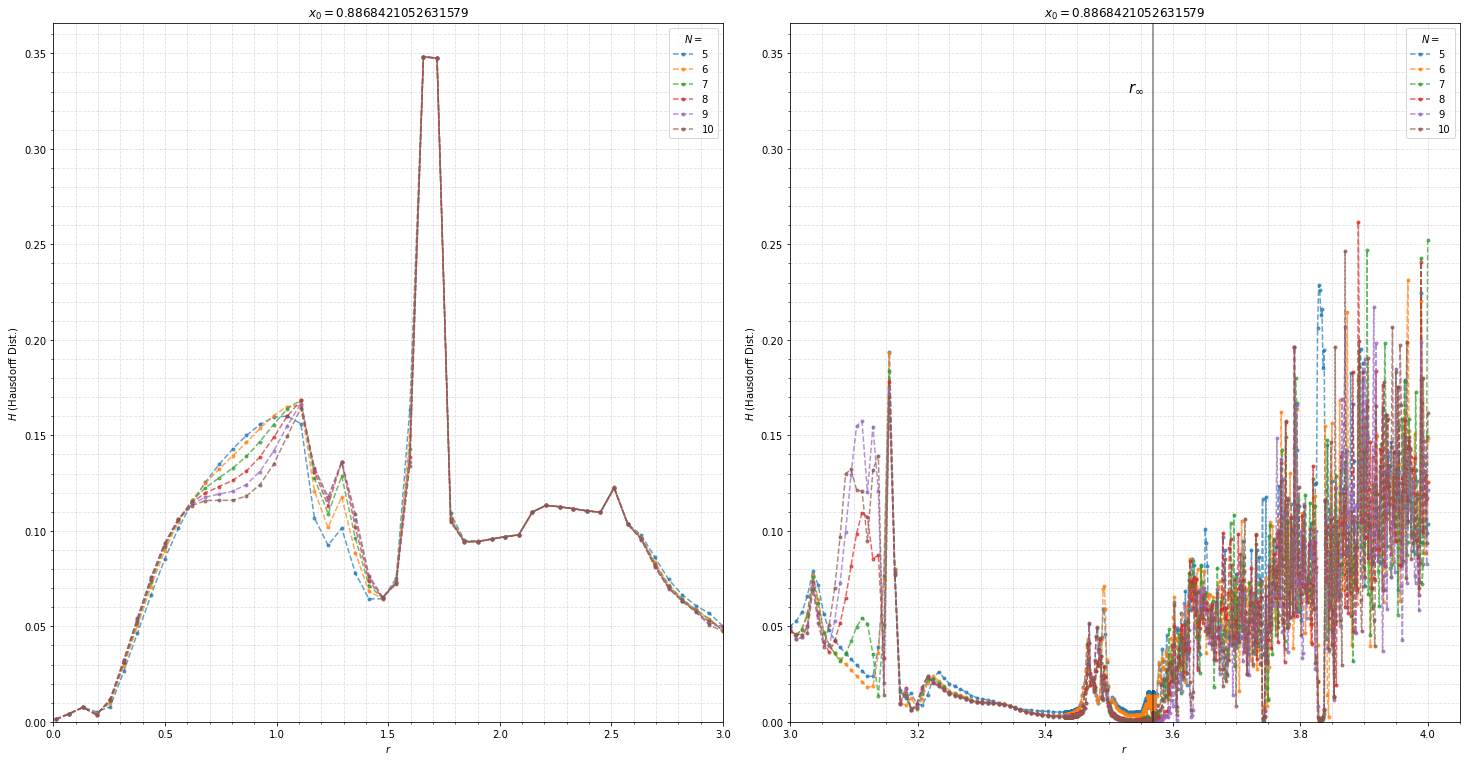

In [465]:
# Change plot
x0_range_i = 17 # range: 0-19
Nmax = 10 # max number of sample points for this data set = 10
Nmin = 5 # Max value = Nmax

# First Plot:
fig = plt.figure(figsize=(0.7*0.5*dpi,0.7*0.25*dpi),dpi=dpi)
ax = fig.add_subplot(121)

x0_i = x0_range[x0_range_i]
for n_i in range(Nmin,Nmax + 1):
    ax.plot(result[n_i - 2][x0_range_i][0],result[n_i - 2][x0_range_i][1],'--',marker='.', alpha=0.7, lw=1.5)

# Annotate and tidy the plot.
ax.minorticks_on()
ax.grid(which='minor', alpha=0.4, ls='--')
ax.grid(which='major', alpha=0.4, ls='--')
ax.set_xlabel(r'$r$')
ax.set_ylabel(r'$H$ (Hausdorff Dist.)')
ax.set_title(r'$x_0 = {one}$'.format(one = x0_i))
ax.legend(labels=range(Nmin,Nmax + 1),title="$N=$");
ax.set_ylim(bottom=0);
ax.set_xlim(left=0,right=3);

#---
#Second Plot:
#fig = plt.figure(figsize=(0.7*0.5*dpi,0.7*0.25*dpi),dpi=dpi)
ax = fig.add_subplot(122)

x0_i = x0_range[x0_range_i]
for n_i in range(Nmin,Nmax + 1):
    ax.plot(result[n_i - 2][x0_range_i][0],result[n_i - 2][x0_range_i][1],'--',marker='.', alpha=0.7, lw=1.5)

# Annotate and tidy the plot.
ax.minorticks_on()
ax.grid(which='minor', alpha=0.4, ls='--')
ax.grid(which='major', alpha=0.4, ls='--')
ax.set_xlabel(r'$r$')
ax.set_ylabel(r'$H$ (Hausdorff Dist.)')
ax.set_title(r'$x_0 = {one}$'.format(one = x0_i))
ax.legend(labels=range(Nmin,Nmax + 1),title="$N=$");
ax.set_ylim(bottom=0);
ax.set_xlim(left=3, right=4.05);

#Bifurcation points:
ax.axvline(x=3.569946,c="k",alpha=0.5) # r_\infty
ax.text(3.53,0.33,r"$r_\infty$", fontsize=15)

plt.subplots_adjust(wspace=0.1)

Plot 2

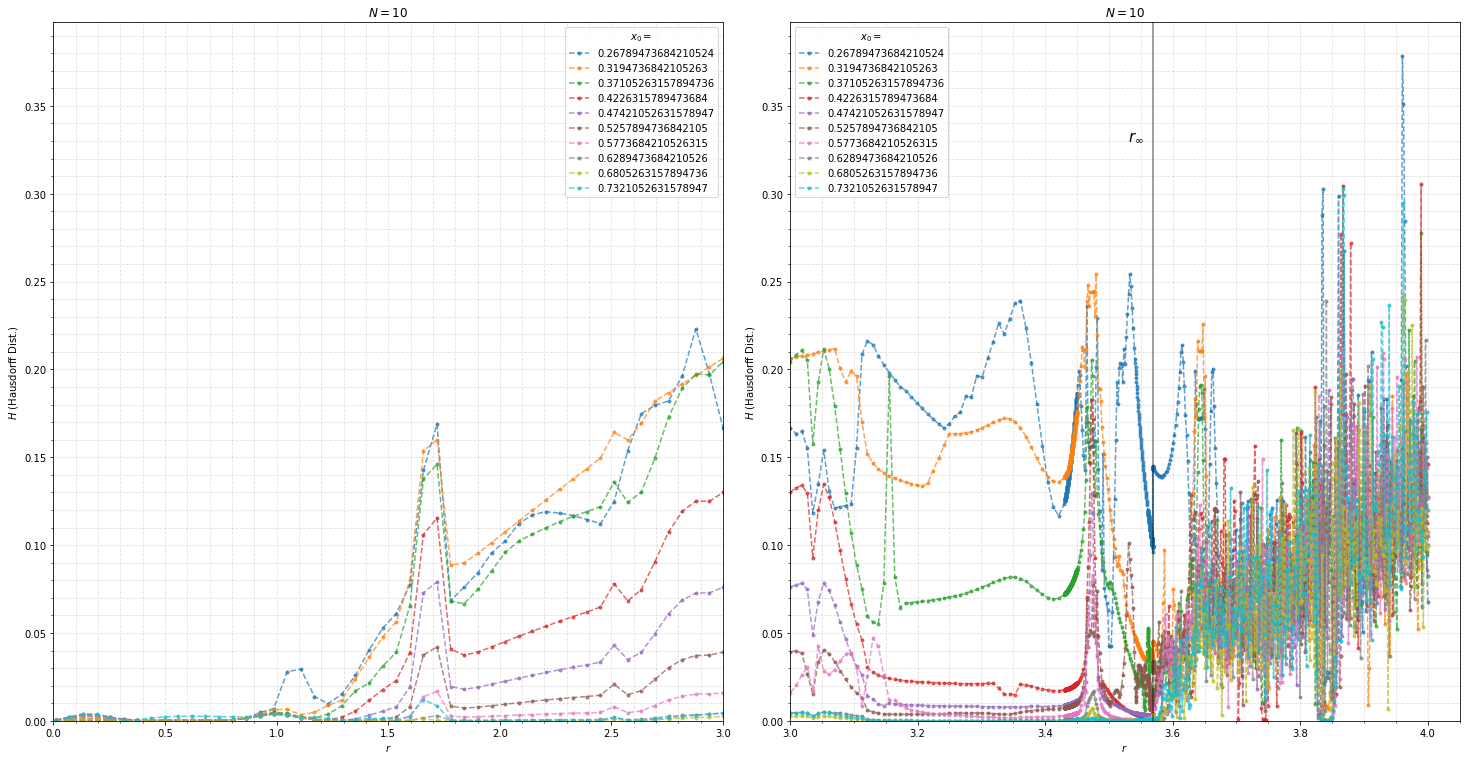

In [470]:
# Change plot
Nmax = 10 # max number of sample points for this data set = 10
Nmin = Nmax # Max value = Nmax
start = 5
end = len(x0_range) - start

# First Plot:
fig = plt.figure(figsize=(0.7*0.5*dpi,0.7*0.25*dpi),dpi=dpi)
ax = fig.add_subplot(121)

for x0_range_i in range(len(x0_range[start:end])):
    ax.plot(result[Nmax - 2][x0_range_i][0],result[Nmax - 2][x0_range_i][1],'--',marker='.', alpha=0.7, lw=1.5)

# Annotate and tidy the plot.
ax.minorticks_on()
ax.grid(which='minor', alpha=0.4, ls='--')
ax.grid(which='major', alpha=0.4, ls='--')
ax.set_xlabel(r'$r$')
ax.set_ylabel(r'$H$ (Hausdorff Dist.)')
ax.set_title(r'$N = {one}$'.format(one = Nmax))
ax.legend(labels=x0_range[start:end],title="$x_0=$");
ax.set_ylim(bottom=0);
ax.set_xlim(left=0,right=3);

#---
#Second Plot:
#fig = plt.figure(figsize=(0.7*0.5*dpi,0.7*0.25*dpi),dpi=dpi)
ax = fig.add_subplot(122)

for x0_range_i in range(len(x0_range[start:end])):
    ax.plot(result[Nmax - 2][x0_range_i][0],result[Nmax - 2][x0_range_i][1],'--',marker='.', alpha=0.7, lw=1.5)

# Annotate and tidy the plot.
ax.minorticks_on()
ax.grid(which='minor', alpha=0.4, ls='--')
ax.grid(which='major', alpha=0.4, ls='--')
ax.set_xlabel(r'$r$')
ax.set_ylabel(r'$H$ (Hausdorff Dist.)')
ax.set_title(r'$N = {one}$'.format(one = Nmax))
ax.legend(labels=x0_range[start:end],title="$x_0=$");
ax.set_ylim(bottom=0);
ax.set_xlim(left=3, right=4.05);

#Bifurcation points:
ax.axvline(x=3.569946,c="k",alpha=0.5) # r_\infty
ax.text(3.53,0.33,r"$r_\infty$", fontsize=15)

plt.subplots_adjust(wspace=0.1)

### Experiment 1 a-2) Time series distribution with starting value 0.4
Relationship between $r$ and $H$ with varying $N$ and $x_0$. 

Setup

In [13]:

Nmax = 10 # max number of sample points
Nmin = 3
#--------------------
r1 = np.linspace(0.01, 3, 75)
r2 = np.linspace(3.01, 3.43, 100)
r3 = np.linspace(3.431, 3.45, 100)
r4 = np.linspace(3.451, 3.54, 50)
r5 = np.linspace(3.541, 3.56, 50)
r6 = np.linspace(3.561, 3.565, 50)
r7 = np.linspace(3.5651,3.5699, 150)
r8 = np.linspace(3.56991,3.5699461, 50)
r9 = np.linspace(3.569947,4, 200)
r_range = np.concatenate((r1,r2,r3,r4,r5,r6,r7,r8,r9)) # range of r values
print(len(r_range))
#r_range = np.linspace(0.01,4,3)
#-------------------
# choose one:
x0_range = np.linspace(0.01,0.99,15)
#x0_range = np.linspace(0.01,0.99,3)
#x0_i = 0.2 # initial orbit position for cobweb
#------------------
# for time series dist only -> choose one:
#x0_time_dist_range = np.linspace(0.01,0.99,20)
x0_time_dist_i = 0.4 # time series dist x0 starting value
#------------------
nmax = 100 # max iterations of orbit for Hausdorff dist. calculation

#===================================

Xnew = np.linspace(-0.05, 1.05, 100)[:, None]
result = []
N_Array = []
R = []
H = []

# -- Approximate Calculation Time: --
start_time = timeit.default_timer()

k = GPy.kern.RBF(1,variance=1.,lengthscale=0.1,name="rbf")
f = lambda x: 4*x*(1-x)
X = time_series_dist(0.4,Nmax)[:,None]
#X,N = declump(X,Nmax,2);
sd = 0
ep = np.random.normal(0., sd, (Nmax,1))
Y = f(X) + ep
m = GPy.models.GPRegression(X, Y, k)
m.constrain_positive(warning=False)
m.Gaussian_noise.variance = sd**2
m.Gaussian_noise.variance.fix()
m.optimize()
mean, Cov = m.predict_noiseless(Xnew, full_cov=True)
#--------
h = Hausdorff(0.2,nmax,m,f,500)
#--------
R.append(4)
H.append(h)
X0_Array = [R,H]
N_Array.append(X0_Array)
result.append(N_Array)

elapsed = timeit.default_timer() - start_time
multiplier = (Nmax-Nmin) * len(x0_range) * len(r_range)
print(str(multiplier) + " x " + str(elapsed) + " seconds.")
elapsed = elapsed * multiplier
print("Approximate calculation time needed: " + str(elapsed) + " seconds = " + str(elapsed/60) + " minutes = " + str(elapsed/3600) + " hours.")
print("Approximate calculation time needed: " + str(np.floor(elapsed/3600)) + " hrs, " + str(np.floor((elapsed/3600-np.floor(elapsed/3600))*60)) + " min, " + str(((elapsed/3600-np.floor(elapsed/3600))*60 - np.floor((elapsed/3600-np.floor(elapsed/3600))*60))*60) + " sec.")

825
86625 x 0.7317515000000014 seconds.
Approximate calculation time needed: 63387.973687500125 seconds = 1056.466228125002 minutes = 17.607770468750036 hours.
Approximate calculation time needed: 17.0 hrs, 36.0 min, 27.973687500131348 sec.


Experiment

In [63]:
Xnew = np.linspace(-0.05, 1.05, 100)[:, None]

result = []
for n_i in range(Nmin,Nmax + 1):
    N_Array = []
    for x0_i in x0_range:
        R = []
        H = []
        for r_i in r_range:
            k = GPy.kern.RBF(1,variance=1.,lengthscale=0.1,name="rbf")
            # -- Recalculate GP fit: -- 
            f = lambda x: r_i*x*(1-x)
            X = time_series_dist(x0_time_dist_i,n_i)[:,None]
            #X,N = declump(X,n_i,2);
            sd = 0
            ep = np.random.normal(0., sd, (n_i,1))
            Y = f(X) + ep
            m = GPy.models.GPRegression(X, Y, k)
            m.constrain_positive(warning=False)
            m.Gaussian_noise.variance = sd**2
            m.Gaussian_noise.variance.fix()
            m.optimize()
            mean, Cov = m.predict_noiseless(Xnew, full_cov=True)
            #--------
            h = Hausdorff(x0_i,nmax,m,f,500)
            #--------
            R.append(r_i)
            H.append(h)
        X0_Array = [R,H]
        N_Array.append(X0_Array)
    result.append(N_Array)
    update_progress(n_i/Nmax)
#np.save('Experiment1a.npy', result)

Progress: [####################] 100.0%


Results

In [16]:
result = np.load('Experiment1a.npy')

Plot 1

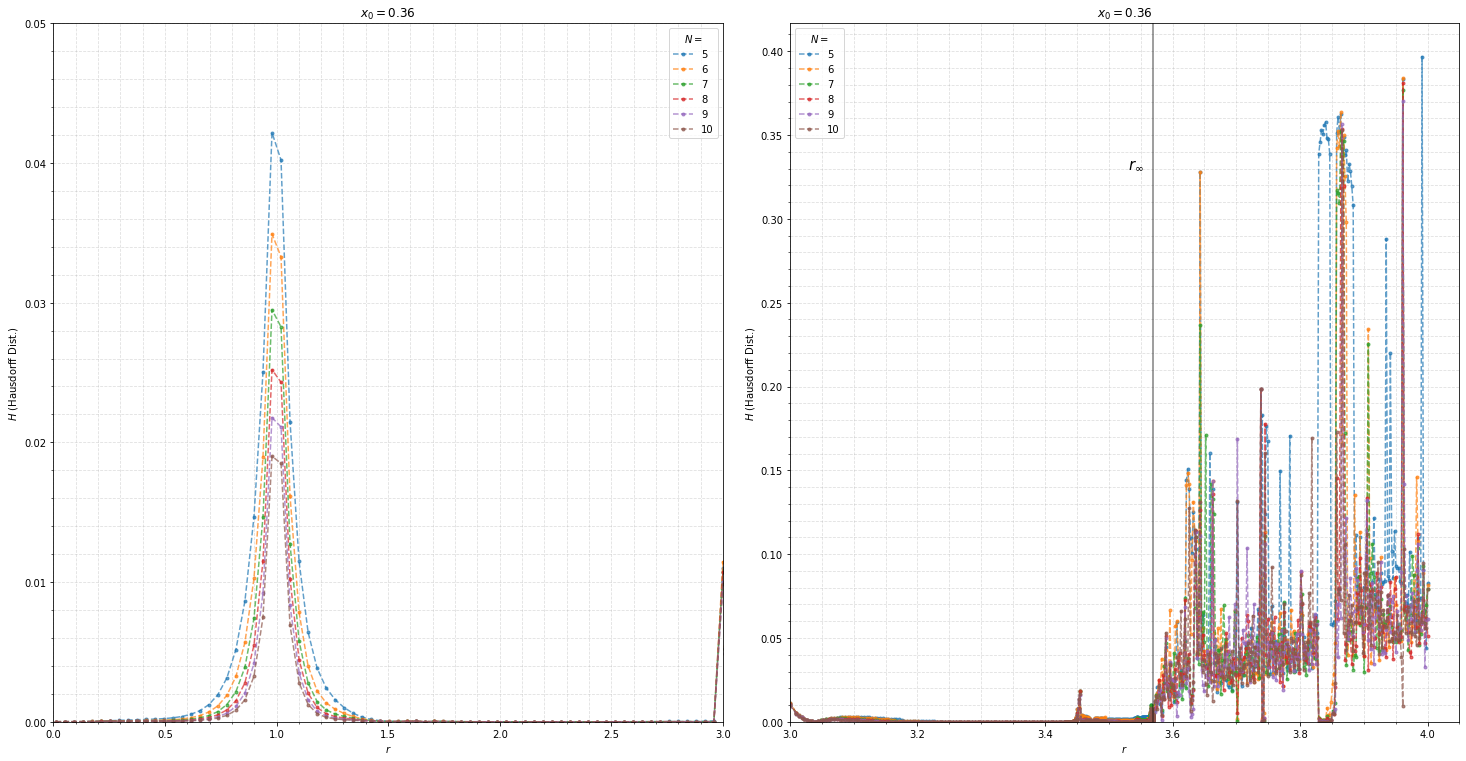

In [28]:
# Change plot
x0_range_i = 5 # range: 0-15
Nmax = 10 # max number of sample points for this data set = 10
Nmin = 5 # Max value = Nmax

# First Plot:
fig = plt.figure(figsize=(0.7*0.5*dpi,0.7*0.25*dpi),dpi=dpi)
ax = fig.add_subplot(121)

x0_i = x0_range[x0_range_i]
for n_i in range(Nmin,Nmax + 1):
    ax.plot(result[n_i - 3][x0_range_i][0],result[n_i - 3][x0_range_i][1],'--',marker='.', alpha=0.7, lw=1.5)

# Annotate and tidy the plot.
ax.minorticks_on()
ax.grid(which='minor', alpha=0.4, ls='--')
ax.grid(which='major', alpha=0.4, ls='--')
ax.set_xlabel(r'$r$')
ax.set_ylabel(r'$H$ (Hausdorff Dist.)')
ax.set_title(r'$x_0 = {one}$'.format(one = x0_i))
ax.legend(labels=range(Nmin,Nmax + 1),title="$N=$");
ax.set_ylim(bottom=0,top=0.05);
ax.set_xlim(left=0,right=3);

#---
#Second Plot:
#fig = plt.figure(figsize=(0.7*0.5*dpi,0.7*0.25*dpi),dpi=dpi)
ax = fig.add_subplot(122)

x0_i = x0_range[x0_range_i]
for n_i in range(Nmin,Nmax + 1):
    ax.plot(result[n_i - 3][x0_range_i][0],result[n_i - 3][x0_range_i][1],'--',marker='.', alpha=0.7, lw=1.5)

# Annotate and tidy the plot.
ax.minorticks_on()
ax.grid(which='minor', alpha=0.4, ls='--')
ax.grid(which='major', alpha=0.4, ls='--')
ax.set_xlabel(r'$r$')
ax.set_ylabel(r'$H$ (Hausdorff Dist.)')
ax.set_title(r'$x_0 = {one}$'.format(one = x0_i))
ax.legend(labels=range(Nmin,Nmax + 1),title="$N=$");
ax.set_ylim(bottom=0);
ax.set_xlim(left=3, right=4.05);

#Bifurcation points:
ax.axvline(x=3.569946,c="k",alpha=0.5) # r_\infty
ax.text(3.53,0.33,r"$r_\infty$", fontsize=15)

plt.subplots_adjust(wspace=0.1)

Text(3.53, 0.015, '$r_\\infty$')

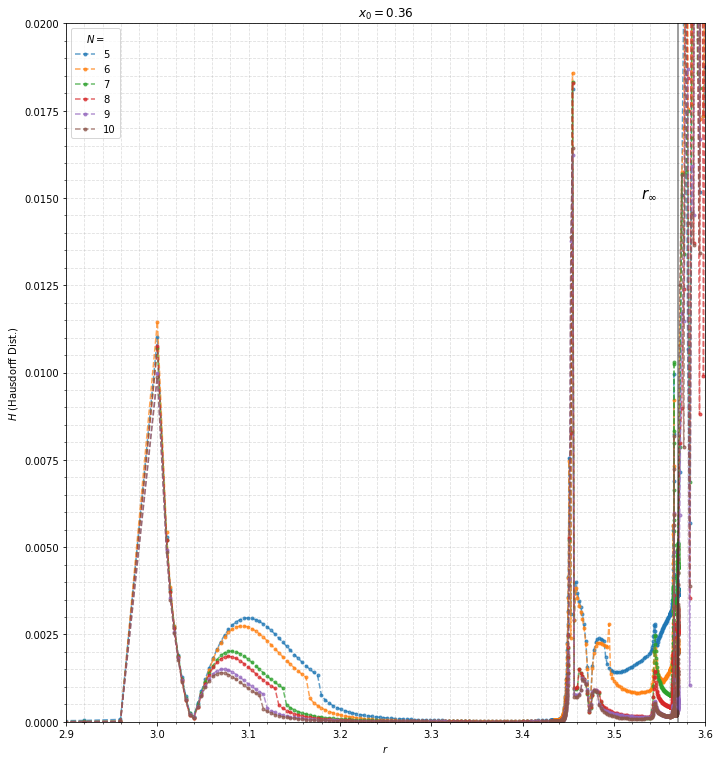

In [39]:
# Change plot
x0_range_i = 5 # range: 0-15
Nmax = 10 # max number of sample points for this data set = 10
Nmin = 5 # Max value = Nmax

# First Plot:
fig = plt.figure(figsize=(0.7*0.5*dpi,0.7*0.25*dpi),dpi=dpi)
ax = fig.add_subplot(121)

x0_i = x0_range[x0_range_i]
for n_i in range(Nmin,Nmax + 1):
    ax.plot(result[n_i - 3][x0_range_i][0],result[n_i - 3][x0_range_i][1],'--',marker='.', alpha=0.7, lw=1.5)

# Annotate and tidy the plot.
ax.minorticks_on()
ax.grid(which='minor', alpha=0.4, ls='--')
ax.grid(which='major', alpha=0.4, ls='--')
ax.set_xlabel(r'$r$')
ax.set_ylabel(r'$H$ (Hausdorff Dist.)')
ax.set_title(r'$x_0 = {one}$'.format(one = x0_i))
ax.legend(labels=range(Nmin,Nmax + 1),title="$N=$");
ax.set_ylim(bottom=0,top=0.02);
ax.set_xlim(left=2.9, right=3.6);

#Bifurcation points:
ax.axvline(x=3.569946,c="k",alpha=0.5) # r_\infty
ax.text(3.53,0.015,r"$r_\infty$", fontsize=15)

Text(3.56, 0.015, '$r_\\infty$')

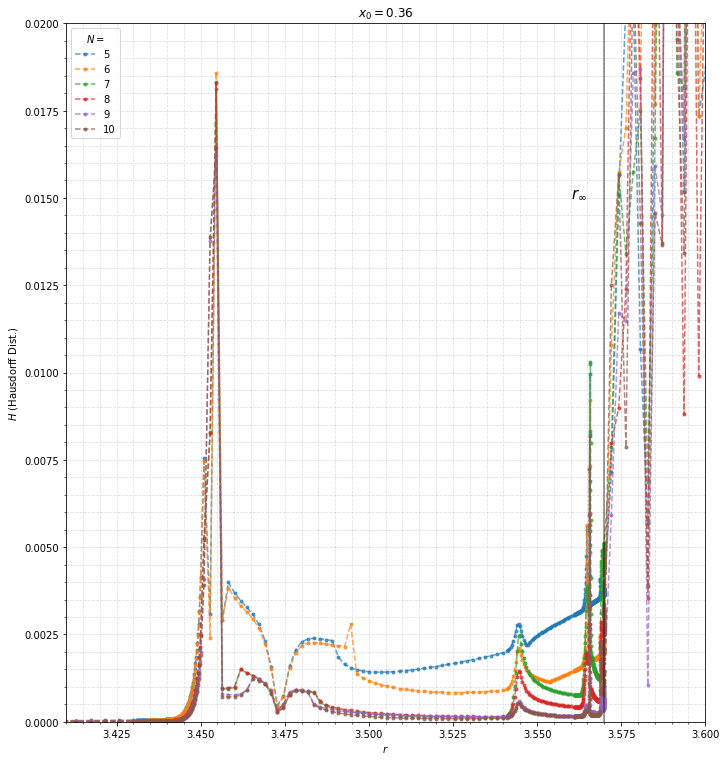

In [42]:
# Change plot
x0_range_i = 5 # range: 0-15
Nmax = 10 # max number of sample points for this data set = 10
Nmin = 5 # Max value = Nmax

# First Plot:
fig = plt.figure(figsize=(0.7*0.5*dpi,0.7*0.25*dpi),dpi=dpi)
ax = fig.add_subplot(121)

x0_i = x0_range[x0_range_i]
for n_i in range(Nmin,Nmax + 1):
    ax.plot(result[n_i - 3][x0_range_i][0],result[n_i - 3][x0_range_i][1],'--',marker='.', alpha=0.7, lw=1.5)

# Annotate and tidy the plot.
ax.minorticks_on()
ax.grid(which='minor', alpha=0.4, ls='--')
ax.grid(which='major', alpha=0.4, ls='--')
ax.set_xlabel(r'$r$')
ax.set_ylabel(r'$H$ (Hausdorff Dist.)')
ax.set_title(r'$x_0 = {one}$'.format(one = x0_i))
ax.legend(labels=range(Nmin,Nmax + 1),title="$N=$");
ax.set_ylim(bottom=0,top=0.02);
ax.set_xlim(left=3.41, right=3.6);

#Bifurcation points:
ax.axvline(x=3.569946,c="k",alpha=0.5) # r_\infty
ax.text(3.56,0.015,r"$r_\infty$", fontsize=15)

Text(3.56, 0.015, '$r_\\infty$')

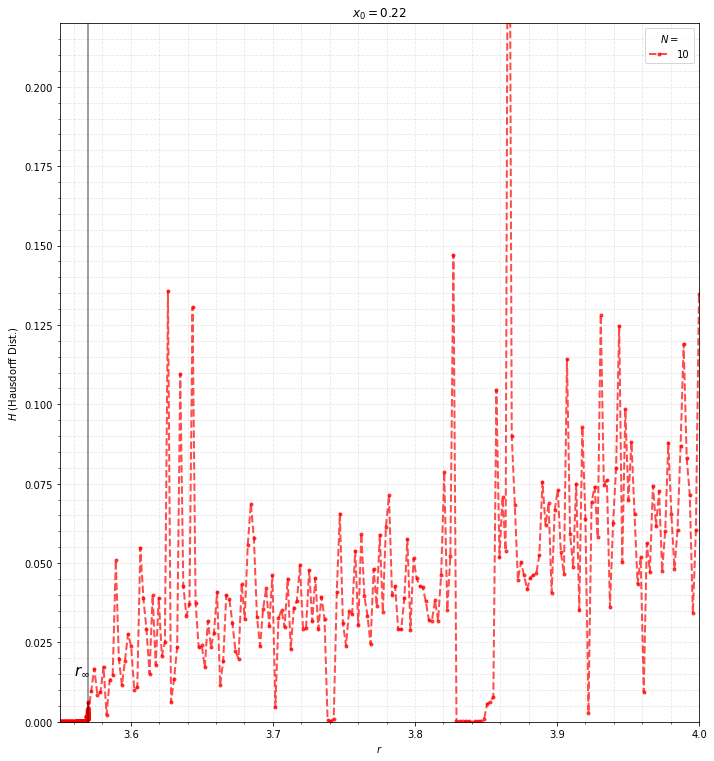

In [56]:
# Change plot
x0_range_i = 3 # range: 0-15
Nmax = 10 # max number of sample points for this data set = 10
Nmin = 10 # Max value = Nmax

# First Plot:
fig = plt.figure(figsize=(0.7*0.5*dpi,0.7*0.25*dpi),dpi=dpi)
ax = fig.add_subplot(121)

x0_i = x0_range[x0_range_i]
for n_i in range(Nmin,Nmax + 1):
    ax.plot(result[n_i - 3][x0_range_i][0],result[n_i - 3][x0_range_i][1],'--',marker='.', alpha=0.7, lw=2, c = 'r')

# Annotate and tidy the plot.
ax.minorticks_on()
ax.grid(which='minor', alpha=0.3, ls='--')
ax.grid(which='major', alpha=0.3, ls='--')
ax.set_xlabel(r'$r$')
ax.set_ylabel(r'$H$ (Hausdorff Dist.)')
ax.set_title(r'$x_0 = {one}$'.format(one = np.around(x0_i,2)))
ax.legend(labels=range(Nmin,Nmax + 1),title="$N=$");
ax.set_ylim(bottom=0,top=0.22);
ax.set_xlim(left=3.55, right=4);

#Bifurcation points:
ax.axvline(x=3.569946,c="k",alpha=0.5) # r_\infty
ax.text(3.56,0.015,r"$r_\infty$", fontsize=15)

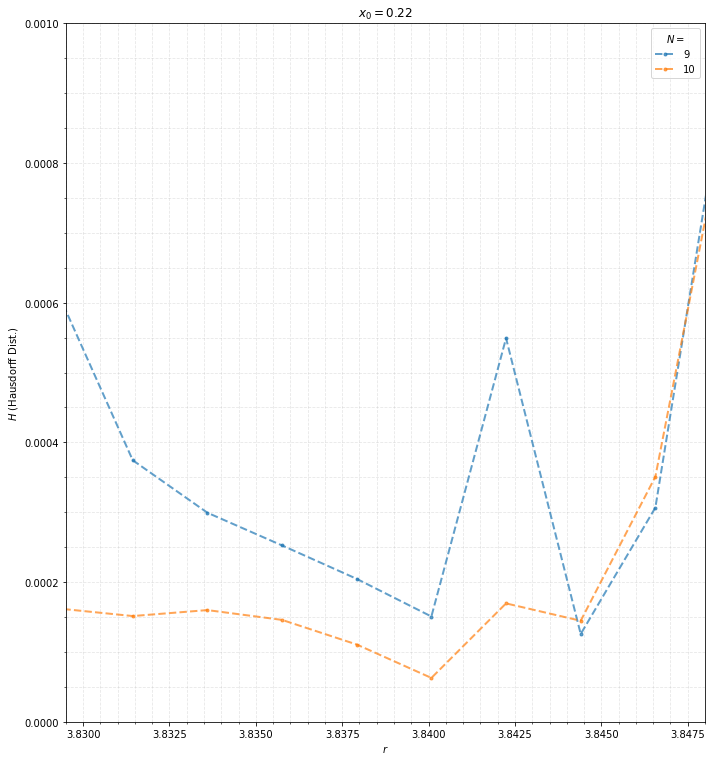

In [70]:
# Change plot
x0_range_i = 3 # range: 0-15
Nmax = 10 # max number of sample points for this data set = 10
Nmin = 9 # Max value = Nmax

# First Plot:
fig = plt.figure(figsize=(0.7*0.5*dpi,0.7*0.25*dpi),dpi=dpi)
ax = fig.add_subplot(121)

x0_i = x0_range[x0_range_i]
for n_i in range(Nmin,Nmax + 1):
    ax.plot(result[n_i - 3][x0_range_i][0],result[n_i - 3][x0_range_i][1],'--',marker='.', alpha=0.7, lw=2)

# Annotate and tidy the plot.
ax.minorticks_on()
ax.grid(which='minor', alpha=0.3, ls='--')
ax.grid(which='major', alpha=0.3, ls='--')
ax.set_xlabel(r'$r$')
ax.set_ylabel(r'$H$ (Hausdorff Dist.)')
ax.set_title(r'$x_0 = {one}$'.format(one = np.around(x0_i,2)))
ax.legend(labels=range(Nmin,Nmax + 1),title="$N=$");
ax.set_ylim(bottom=0,top=0.001);
ax.set_xlim(left=3.8295, right=3.848);

Plot 2

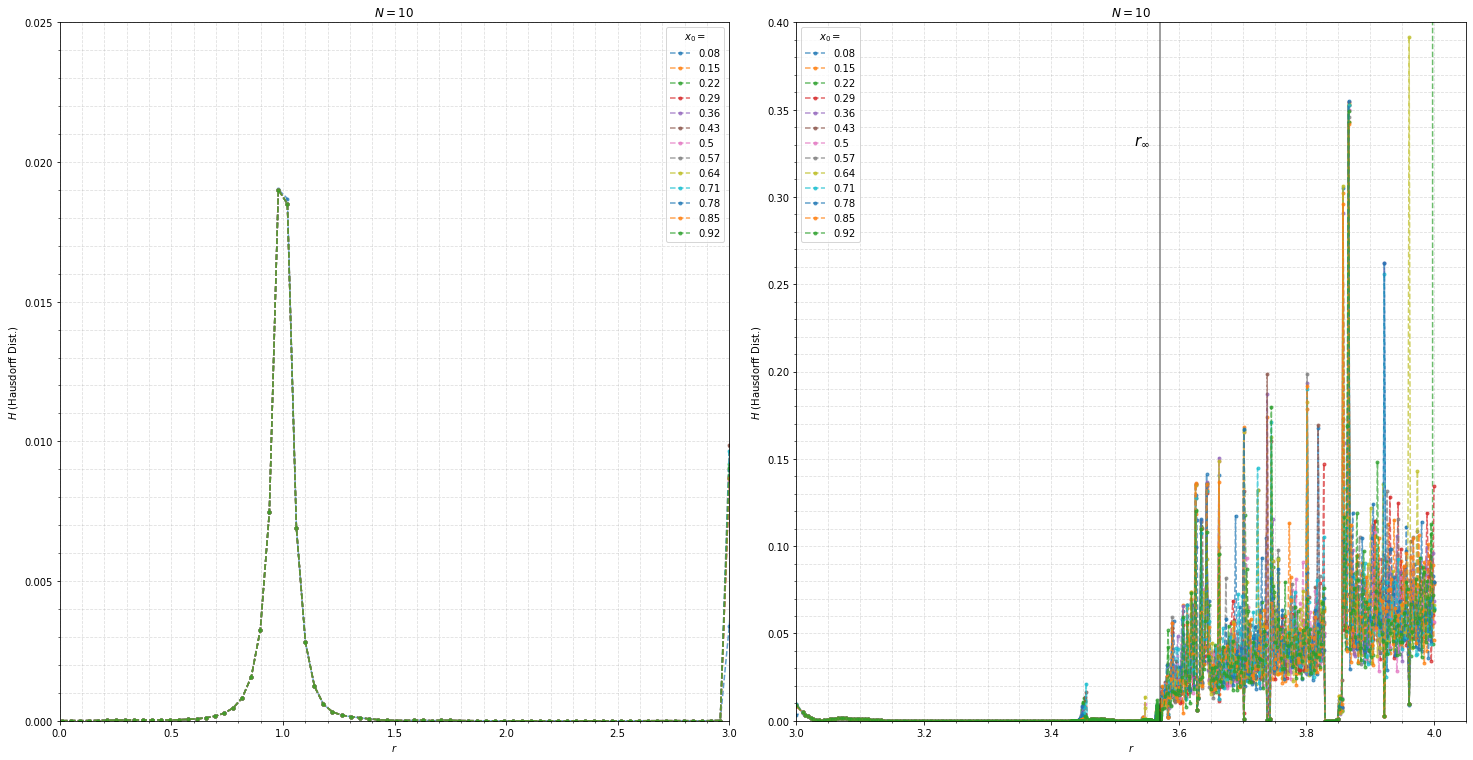

In [27]:
# Change plot
Nmax = 10 # max number of sample points for this data set = 10
Nmin = Nmax # Max value = Nmax
start = 1
end = len(x0_range) - start

# First Plot:
fig = plt.figure(figsize=(0.7*0.5*dpi,0.7*0.25*dpi),dpi=dpi)
ax = fig.add_subplot(121)

for x0_range_i in range(len(x0_range[start:end])):
    ax.plot(result[Nmax - 3][x0_range_i][0],result[Nmax - 3][x0_range_i][1],'--',marker='.', alpha=0.7, lw=1.5)

# Annotate and tidy the plot.
ax.minorticks_on()
ax.grid(which='minor', alpha=0.4, ls='--')
ax.grid(which='major', alpha=0.4, ls='--')
ax.set_xlabel(r'$r$')
ax.set_ylabel(r'$H$ (Hausdorff Dist.)')
ax.set_title(r'$N = {one}$'.format(one = Nmax))
ax.legend(labels=np.around(x0_range,2)[start:end],title="$x_0=$");
ax.set_ylim(bottom=0,top=0.025);
ax.set_xlim(left=0,right=3);

#---
#Second Plot:
#fig = plt.figure(figsize=(0.7*0.5*dpi,0.7*0.25*dpi),dpi=dpi)
ax = fig.add_subplot(122)

for x0_range_i in range(len(x0_range[start:end])):
    ax.plot(result[Nmax - 3][x0_range_i][0],result[Nmax - 3][x0_range_i][1],'--',marker='.', alpha=0.7, lw=1.5)

# Annotate and tidy the plot.
ax.minorticks_on()
ax.grid(which='minor', alpha=0.4, ls='--')
ax.grid(which='major', alpha=0.4, ls='--')
ax.set_xlabel(r'$r$')
ax.set_ylabel(r'$H$ (Hausdorff Dist.)')
ax.set_title(r'$N = {one}$'.format(one = Nmax))
ax.legend(labels=np.around(x0_range,2)[start:end],title="$x_0=$");
ax.set_ylim(bottom=0,top=0.4);
ax.set_xlim(left=3, right=4.05);

#Bifurcation points:
ax.axvline(x=3.569946,c="k",alpha=0.5) # r_\infty
ax.text(3.53,0.33,r"$r_\infty$", fontsize=15)

plt.subplots_adjust(wspace=0.1)

Text(3.555, 0.02, '$r_\\infty$')

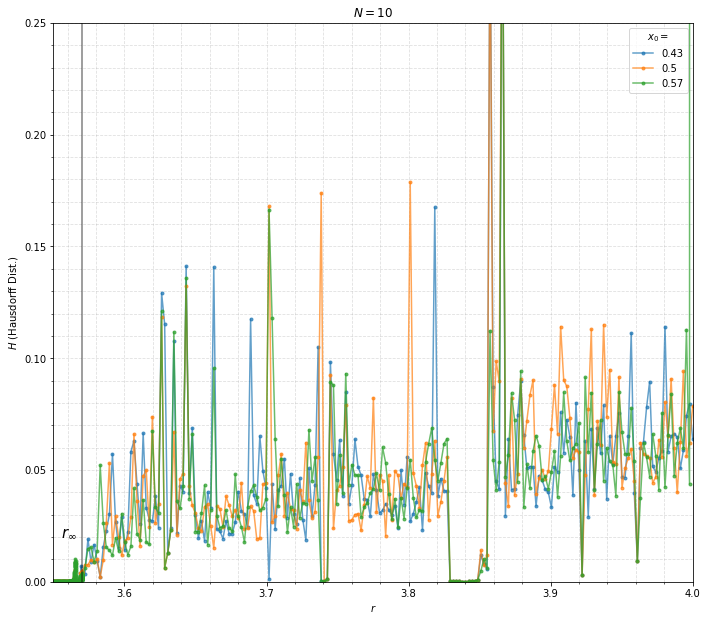

In [93]:
# Change plot
Nmax = 10 # max number of sample points for this data set = 10
Nmin = Nmax # Max value = Nmax
start = 6
end = len(x0_range) - start

fig = plt.figure(figsize=(0.7*0.5*dpi,0.7*0.2*dpi),dpi=dpi)
ax = fig.add_subplot(121)

for x0_range_i in range(len(x0_range[start:end])):
    ax.plot(result[Nmax - 3][x0_range_i][0],result[Nmax - 3][x0_range_i][1],ls='-',marker='.', alpha=0.7, lw=1.5)

# Annotate and tidy the plot.
ax.minorticks_on()
ax.grid(which='minor', alpha=0.4, ls='--')
ax.grid(which='major', alpha=0.4, ls='--')
ax.set_xlabel(r'$r$')
ax.set_ylabel(r'$H$ (Hausdorff Dist.)')
ax.set_title(r'$N = {one}$'.format(one = Nmax))
ax.legend(labels=np.around(x0_range,2)[start:end],title="$x_0=$");
ax.set_ylim(bottom=0,top=0.25);
ax.set_xlim(left=3.55, right=4);

#Bifurcation points:
ax.axvline(x=3.569946,c="k",alpha=0.5) # r_\infty
ax.text(3.555,0.02,r"$r_\infty$", fontsize=15)